In [117]:
import numpy as np

# Read data
data = np.fromfile('../data/Oxford105K/CNNdesc105k.dat', dtype=np.float32).reshape(-1, 128)
print(f'Data shape: {data.shape}')

names = []
path_to_img = '../data/Oxford105K/oxc-complete/'

with open('../data/Oxford105K/imagenames105k.txt', 'r') as file:
    for line in file.readlines():
        names.append(path_to_img + line.replace('\n', '').strip() + '.jpg')

Data shape: (104933, 128)


In [30]:
GPU_DEFAULT_INDEX = 0

# Set up the index
index_setup = faiss.IndexFlatL2(data.shape[1])

if faiss.get_num_gpus():
    resources = faiss.StandardGpuResources()
    index = faiss.index_cpu_to_gpu(resources, GPU_DEFAULT_INDEX, index_setup)
else:
    index = index_setup

In [31]:
# Add data to the index
index.add(data)

In [41]:
N_NEIGHBORS = 11

# Query nearest neighbors
sqdist, neighbors = index.search(data, N_NEIGHBORS)
sqdist, neighbors = sqdist[:, 1:], neighbors[:, 1:]

In [54]:
from tqdm import tqdm
import networkx as nx


graph = nx.Graph()

for i, pd, nn in tqdm(
    zip(np.arange(len(neighbors)), sqdist, neighbors), 
    desc='k-NN Graph Creation'
):
    graph.add_weighted_edges_from([(i, n, d) for d, n in zip(pd, nn)], weight='weight', )

k-NN Graph Creation: 104933it [00:03, 31826.89it/s]


In [58]:
print(f'The graph is connected: {nx.algorithms.is_connected(graph)}')

The graph is connected: True


In [148]:
import logging

logging.basicConfig(filename='../data/knn_path.log', mode='w', level=logging.INFO)


POINT_A = 0
POINT_B = 100

MAX_EDGES = 7


# Smooth path evaluation
opt_cost = max(sqdist.ravel())
opt_length = opt_cost * MAX_EDGES
opt_path = None
logging.info(f'Initial cost: {opt_cost}\nInitial path length: {opt_length}')

for i, path in enumerate(
    nx.algorithms.all_simple_paths(graph, source=POINT_A, target=POINT_B, cutoff=MAX_EDGES)
):
    weights = [graph.get_edge_data(path[j], path[j + 1])['weight'] for j in range(len(path) - 1)]
    max_dist = max(weights)
    path_length = sum(weights)
    if max_dist < opt_cost or np.isclose(max_dist, opt_cost) and path_length < opt_length:
        opt_cost = max_dist
        opt_length = path_length     
        opt_path = path
        logging.info(f'New cost and path length: {(opt_cost, opt_length)}')
print(opt_path)

[0, 89900, 56956, 21265, 1506, 1252, 1282, 100]


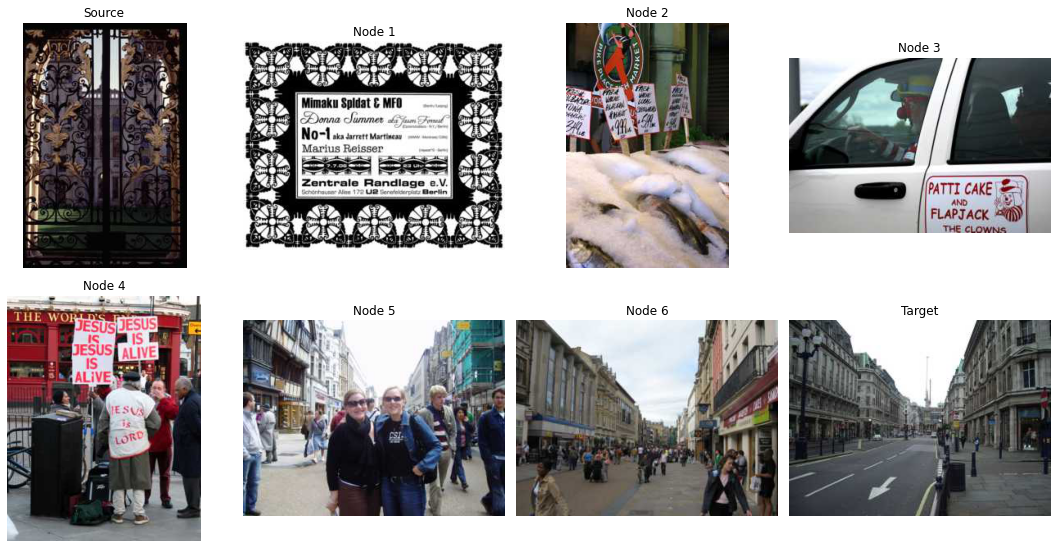

In [153]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

%matplotlib inline


fig, axes = plt.subplots(ncols=4, nrows=2, constrained_layout=True, figsize=(15, 7.5))
if isinstance(axes[0], np.ndarray):
    axes = [ax for sublist in axes for ax in sublist]
titles = ['Source'] + [f'Node {i + 1}' for i in range(len(opt_path) - 2)] + ['Target'] + [''] * (len(axes) - len(opt_path))
images = [names[j] for j in opt_path] + [None] * (len(axes) - len(opt_path))

for ax, image, title in zip(axes, images, titles):
    if image is not None:
        image = Image.open(image, 'r')
        ax.imshow(np.asarray(image))
    ax.axis('off')
    ax.set_title(title)
plt.savefig('../images/knn/path.png')